# Coordinates

## Decode adress from coordinates 
OpenStrettMap, GoogleMaps, reverse_geocoder

In [18]:
import pandas as pd
import numpy as np
import reverse_geocoder as revgc
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
%matplotlib inline

latitude = 40.748817
longitude = -73.985428

revgc.search((latitude, longitude))

[OrderedDict([('lat', '40.74482'),
              ('lon', '-73.94875'),
              ('name', 'Long Island City'),
              ('admin1', 'New York'),
              ('admin2', 'Queens County'),
              ('cc', 'US')])]

## Direct use of coordinates

Consider data with taxi trips. We have coordinated of start point and coordinates of dropoff point.

In [6]:
data = pd.read_csv('../../Data/taxi/train.csv')

In [7]:
y = data["trip_duration"]
X = data.drop(columns=["trip_duration"])

### Distance between points

In [9]:
from haversine import haversine

distance = []
for i in range(len(data)):
    pickup = tuple((data['pickup_latitude'][i], data['pickup_longitude'][i]))
    dropoff = tuple((data['dropoff_latitude'][i], data['dropoff_longitude'][i]))
    distance.append(haversine(pickup, dropoff))

In [11]:
data['haversin'] = distance

### Distance to special points

For example, we can mark if the trip was started or ended at the airport.

In [12]:
laguard_airport_coord= tuple((40.777250, -73.872611))
fkenned_airport_coord= tuple((40.6413111, -73.7781391)) 

In [14]:
data['pickup_coordinates'] = data[['pickup_latitude', 'pickup_longitude']].apply(tuple, axis=1)
data['dropoff_coordinates'] = data[['dropoff_latitude', 'dropoff_longitude']].apply(tuple, axis=1)

data['laguard_haversine_pickup'] = [haversine(data['pickup_coordinates'][i], laguard_airport_coord) for i in range(len(data))] 
data['laguard_haversine_dropoff'] = [haversine(data['dropoff_coordinates'][i], laguard_airport_coord) for i in range(len(data))]
data['fkenned_haversine_pickup'] = [haversine(data['pickup_coordinates'][i], fkenned_airport_coord) for i in range(len(data))]
data['fkenned_haversine_dropoff'] = [haversine(data['dropoff_coordinates'][i], fkenned_airport_coord) for i in range(len(data))]

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # This is added back by InteractiveShellApp.init_path()


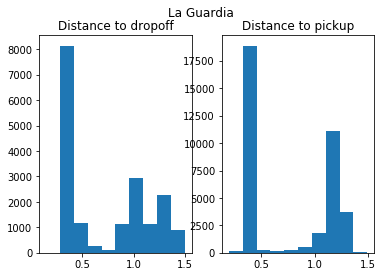

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.hist(data[data['laguard_haversine_dropoff'] <= 1.5]['laguard_haversine_dropoff'])
ax1.set_title('Distance to dropoff')

ax2.hist(data[data['laguard_haversine_pickup'] <= 1.5]['laguard_haversine_pickup'])
ax2.set_title('Distance to pickup')

fig.suptitle('La Guardia')

fig.show()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # This is added back by InteractiveShellApp.init_path()


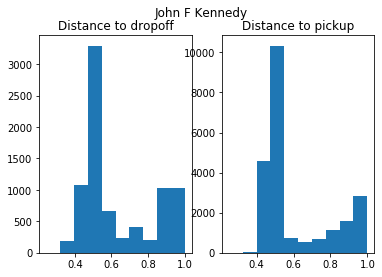

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.hist(data[data['fkenned_haversine_dropoff'] <= 1]['fkenned_haversine_dropoff'])
ax1.set_title('Distance to dropoff')

ax2.hist(data[data['fkenned_haversine_pickup'] <= 1]['fkenned_haversine_pickup'])
ax2.set_title('Distance to pickup')

fig.suptitle('John F Kennedy')

fig.show()

In [21]:
data['laguard_pickup_binary'] = np.where(data['laguard_haversine_pickup'] <= 0.6,1,0) 
data['laguard_dropoff_binary'] = np.where(data['laguard_haversine_dropoff'] <= 0.6,1,0) 
data['fkenned_pickup_binary'] = np.where(data['fkenned_haversine_pickup'] <= 1,1,0) 
data['fkenned_dropoff_binary'] = np.where(data['fkenned_haversine_dropoff'] <= 1,1,0) 

### Split space into areas

for example split dense cluster of points into squares. Create new feature trip started in that point, trip ended in that point.

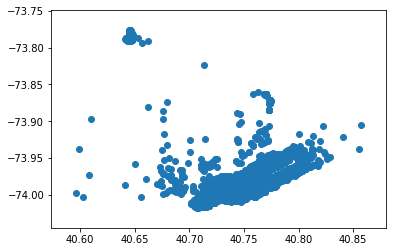

In [27]:
from sklearn.cluster import DBSCAN

data = data.sample(5000)


data = data[(data['pickup_longitude'] >= -76) & (data['pickup_longitude'] <= -73.7)]
data = data[(data['pickup_latitude'] >= 40.5) & (data['pickup_latitude'] <= 40.9)]
data.reset_index(drop=True, inplace=True)

plt.scatter(data['pickup_latitude'], data['pickup_longitude']);

Find dense region

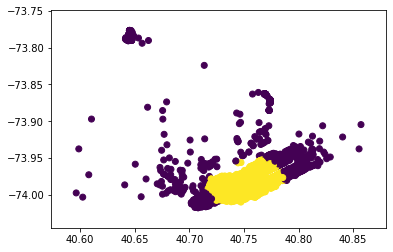

In [30]:
clustering = DBSCAN(eps=0.02, min_samples=1900).fit(data[['pickup_latitude', 'pickup_longitude']])
y  = clustering.labels_

plt.scatter(data['pickup_latitude'], data['pickup_longitude'], c=y);

In [33]:
dense_region = data.loc[np.where(y==0)]

x_grid = np.linspace(dense_region['pickup_latitude'].min(), dense_region['pickup_latitude'].max(), num=3)
y_grid = np.linspace(dense_region['pickup_longitude'].min(), dense_region['pickup_longitude'].max(), num=3)

inds_x = np.digitize(dense_region['pickup_latitude'], x_grid)
inds_y = np.digitize(dense_region['pickup_longitude'], y_grid)

dense_region['pickup_square'] = ["".join(map(str, item)) for item in zip(inds_x, inds_y)]
data['pickup_square'] = [dense_region['pickup_square'][i] if i in dense_region.index else '00' for i in range(len(data))]

In [34]:
data['pickup_square']

0       21
1       00
2       11
3       12
4       21
        ..
4995    12
4996    00
4997    12
4998    22
4999    00
Name: pickup_square, Length: 5000, dtype: object

### Common knowledge

To create features we also can use common knowledge:
* proximity to the metro
* number of storeys
* distance to the nearest store 
* number of ATMs
* height above sea level

If there are coordinates of the end and the beginning of the route we can use followinf features:
* the number of turns along with the ratio of left and right
* the number of traffic lights, junctions, bridges
* complexity of the road